# Semana 1: Exploración del problema y del dataset

## 1. Cargar y visualizar señales ECG

### Recomendación: usar matplotlib, wfdb, scipy.io

In [7]:
# Define una función reutilizable para cargar y plotear un segmento ECG


def plot_ecg_segment(data_dir):
  
    import os
    import scipy.io as sio
    import matplotlib.pyplot as plt
    import numpy as np

     # Buscamos archivos .mat y tomamos sólo el primero
    mat_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.mat')])
    if not mat_files:
        raise FileNotFoundError(f"No se encontraron .mat en {data_dir}")
    file0 = mat_files[0]

    # Cargamos la señal
    mat = sio.loadmat(os.path.join(data_dir, file0))
    if 'val' in mat:
        signal = mat['val']
    elif 'ECG' in mat:
        signal = mat['ECG']
    else:
        raise KeyError("La señal no está bajo 'val' ni 'ECG'")
    signal = signal.flatten()

    # Parámetros internos fijos
    fs = 300            # Hz
    duration = 10       # segundos

    # Tomamos los primeros 10 s
    n_samples = min(len(signal), fs*duration)
    time = np.arange(n_samples) / fs
    segment = signal[:n_samples]


    plt.figure(figsize=(12,4))
    plt.plot(time, segment, lw=0.8)
    plt.title(f"ECG – {file0} ({duration} s)")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.xlim(0, duration)
    plt.show()

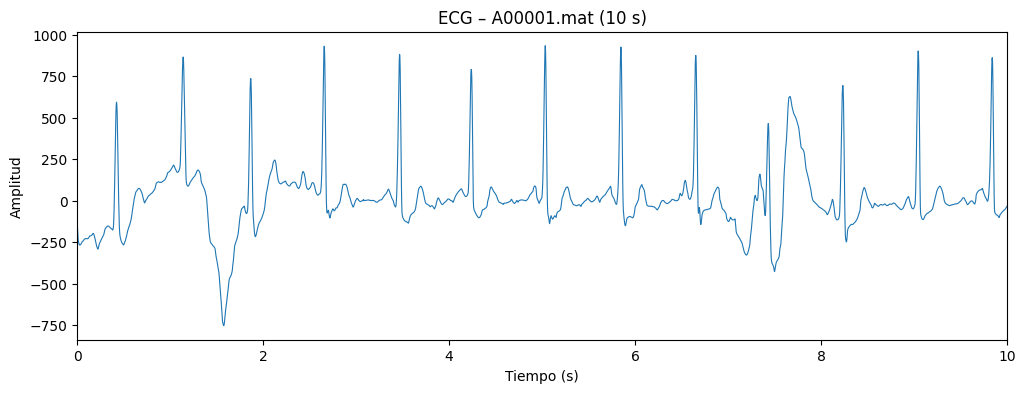

In [8]:
from pathlib import Path

# ./training2017
data_dir = Path("../data/training2017")
plot_ecg_segment(data_dir)

In [23]:
# Celda de instalación y extracción de features (reemplaza la actual)

import os
from pathlib import Path
import scipy.io as sio
from wfdb import rdrecord
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import neurokit2 as nk

# Directorio de registros y etiquetas
data_dir     = Path("../data/training2017")
ref          = pd.read_csv(data_dir/"REFERENCE.csv", header=None, names=['registro','label'])
label_map    = {'N':'Normal','A':'AFib'}
ref['label'] = ref['label'].map(label_map).fillna('Other')
ref_dict     = ref.set_index('registro')['label'].to_dict()

# Parámetros y contenedor
records      = []
fs_target    = 300
max_duration = 10  # segundos

# Recorremos todos los .mat
for fname in sorted(f for f in os.listdir(data_dir) if f.endswith(".mat")):
    rec_name = os.path.splitext(fname)[0]
    # Intentar cargar con wfdb (hea + mat)
    try:
        rec = rdrecord(str(data_dir/rec_name))
        sig = rec.p_signal.flatten()
        fs  = int(rec.fs)
    except:
        # Fallback directo al .mat
        mat = sio.loadmat(data_dir/fname)
        sig = mat.get('val', mat.get('ECG')).flatten()
        fs  = fs_target

    # Recortar a max_duration
    n_samples = min(len(sig), fs * max_duration)
    segment   = sig[:n_samples]

    # Estadísticas de amplitud
    media_mv = segment.mean()
    mstd_mV  = segment.std()
    skewness = skew(segment)
    kurt_val = kurtosis(segment)

    # RR intervals con NeuroKit2
    signals, info = nk.ecg_peaks(segment, sampling_rate=fs)
    rpeaks        = info["ECG_R_Peaks"]
    rr            = np.diff(rpeaks) / fs if len(rpeaks)>1 else np.array([])
    rr_mean_s     = rr.mean() if rr.size>0 else np.nan
    rr_std_s      = rr.std()  if rr.size>0 else np.nan

    # Guardar registro
    records.append({
        'registro':     rec_name,
        'label':        ref_dict.get(rec_name,'Unknown'),
        'fs':           fs,
        'media_mv':     media_mv,
        'mstd_mV':      mstd_mV,
        'skewness':     skewness,
        'kurtosis':     kurt_val,
        'rr_mean_s':    rr_mean_s,
        'rr_std_s':     rr_std_s
    })

# Guardar CSV
df = pd.DataFrame(records)
df.to_csv(Path("../data/ecg_features.csv"), index=False)
print(f"Total registros: {df.shape[0]}")
print("Recuento por clase:")
print(df['label'].value_counts())

Total registros: 60
Recuento por clase:
label
Normal    30
AFib      30
Name: count, dtype: int64


In [21]:
# Celda de “## 2. Inspección básica del dataset” (id: e02aa7d6)
from pathlib import Path
import pandas as pd

csv_path = Path("../data/ecg_features.csv")
df = pd.read_csv(csv_path)

# Mostrar más filas en la vista previa
display(df.head(10))           # ver primeras 50 filas (antes sólo usabas head())
print("Total filas:", df.shape[0])

,registro,label,fs,media_mv,mstd_mV,skewness,kurtosis,rr_mean_s,rr_std_s
0,A00001,Normal,300,0.010062,0.201461,1.223713,5.415730,0.784722,0.030746
1,A00002,Normal,300,0.022602,0.153163,3.262134,21.159241,0.933667,0.214525
2,A00003,Normal,300,0.004400,0.115124,-2.051948,7.019234,0.759394,0.033539
3,A00004,AFib,300,0.052524,0.233103,2.971334,9.351437,1.062917,0.151065
4,A00005,AFib,300,0.008348,0.233297,1.429755,5.001859,0.536667,0.208213
5,A00006,Normal,300,0.001807,0.097949,-1.464060,5.837812,0.972963,0.079682
6,A00007,Normal,300,-0.009349,0.161132,-2.598518,8.997597,0.991667,0.027639
7,A00009,AFib,300,0.004371,0.263764,-0.385587,3.584971,0.632857,0.119263
8,A00018,Normal,300,-0.024892,0.162532,-2.051174,7.524373,1.102917,0.022138
9,A00019,Normal,300,-0.006096,0.109182,-2.050762,12.635354,0.812121,0.140901


Total filas: 60


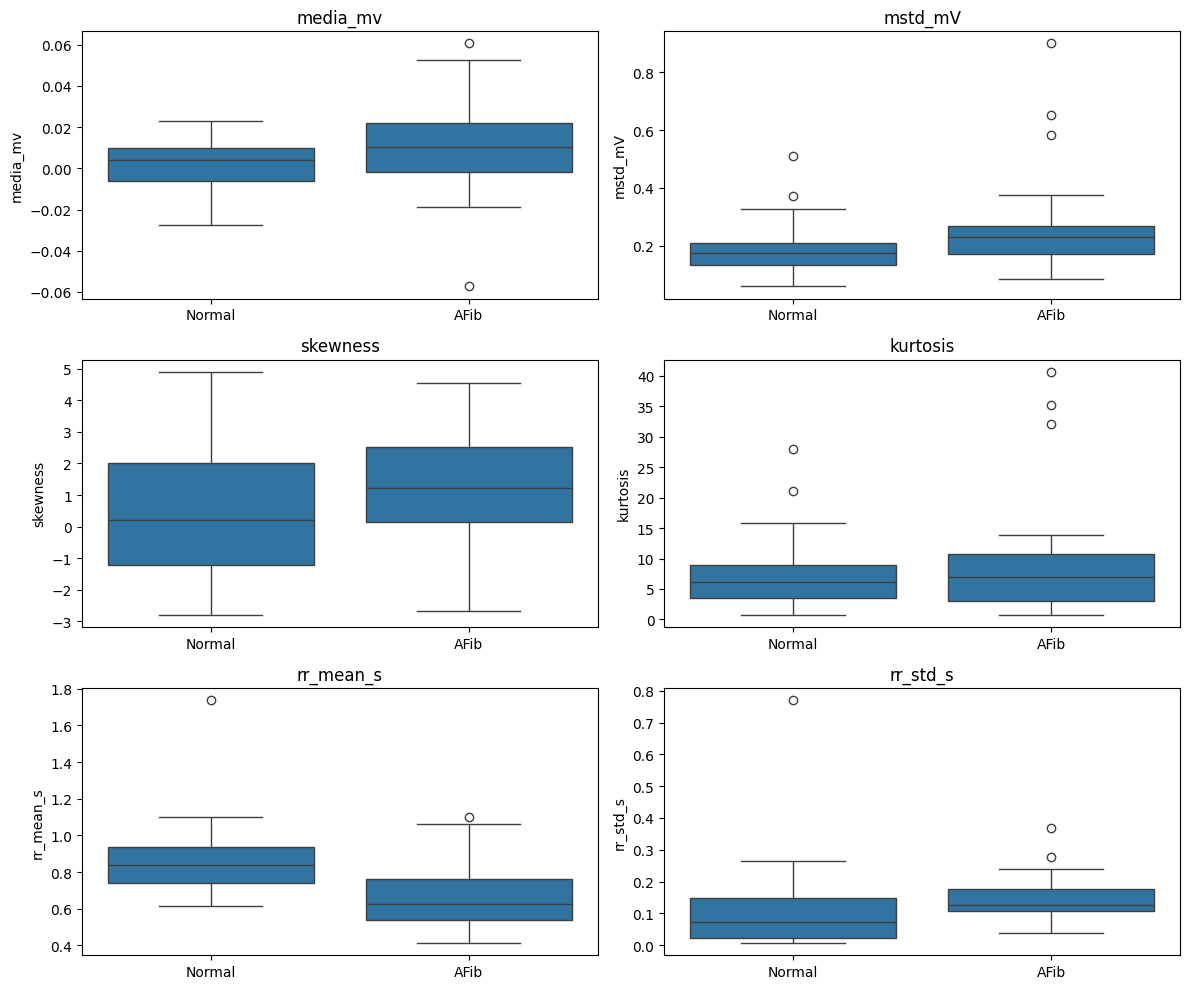

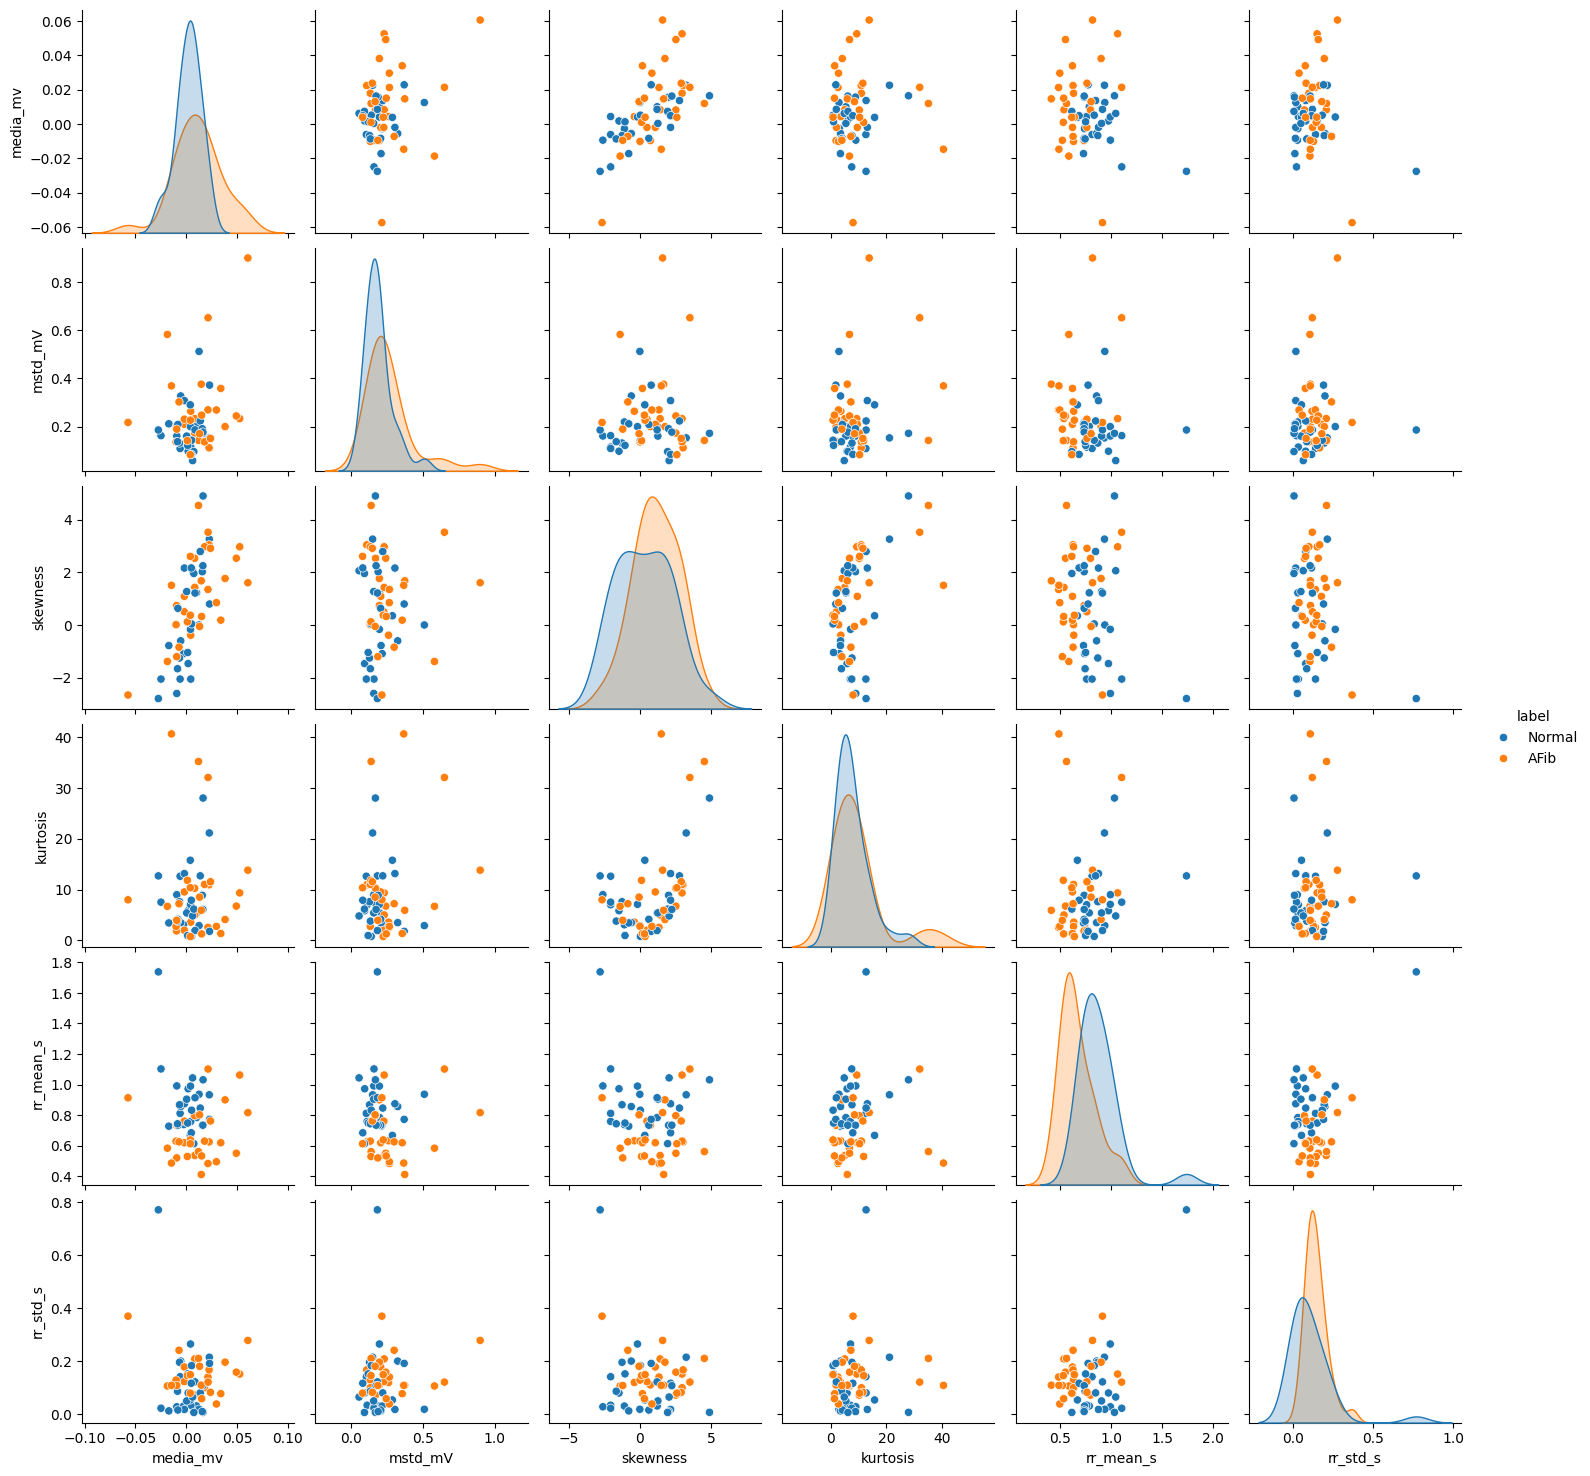

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# 3. Visualización de distribuciones por clase
features = ['media_mv','mstd_mV','skewness','kurtosis','rr_mean_s','rr_std_s']

# Boxplots
fig, axes = plt.subplots(3, 2, figsize=(12,10))
for ax, feat in zip(axes.flatten(), features):
    sns.boxplot(x='label', y=feat, data=df, ax=ax)
    ax.set_title(feat)
    ax.set_xlabel('')
plt.tight_layout()
plt.show()

# Pairplot
sns.pairplot(df, vars=features, hue='label', diag_kind='kde', height=2.5)
plt.show()

**Conlusiones**

1. ¿Qué variables parecen diferenciar más entre clases?  
- **skewness**: la mediana en AFib es claramente positiva frente a la negativa en Normal.  
- **rr_mean_s**: la media de los intervalos RR es menor en AFib (~0.65 s) que en Normal (~0.85 s), mostrando buena separación.  
- **rr_std_s**: la desviación de los RR es notablemente mayor en AFib, reflejando irregularidad.  
- **mstd_mV**: diferencia moderada, con AFib algo más dispersa.  
- **kurtosis**: muy influida por outliers extremos, con menor poder discriminativo global. 

2. ¿Qué aspectos del dataset llaman la atención?  
- Las mejores variables para discriminar son rr_mean_s, rr_std_s y skewness.  
- Gran solapamiento en media_mv y mstd_mV, limita la separación usando sólo amplitud.  
- Kurtosis presenta muchos outliers, conviene robustecer su cálculo o descartarla.  
- El conjunto es pequeño (60 registros, 30 por clase); sería ideal ampliarlo para validar tendencias. 
